In [1]:
from google.colab import drive;
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 56.3 MB/s eta 0:00:00


In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch_geometric.data import Data, Batch
from torch_geometric.nn import SAGEConv
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, roc_curve, auc, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


In [9]:

# Focal Loss Implementation
class FocalLoss(nn.Module):
    def __init__(self, gamma=2, alpha=None, size_average=True):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        if isinstance(alpha, (float, int)):
            self.alpha = torch.Tensor([alpha, 1-alpha])
        if isinstance(alpha, list):
            self.alpha = torch.Tensor(alpha)
        self.size_average = size_average

    def forward(self, input, target):
        if input.dim() > 2:
            input = input.view(input.size(0), input.size(1), -1)
            input = input.transpose(1, 2)
            input = input.contiguous().view(-1, input.size(2))
        target = target.view(-1, 1)
        logpt = F.log_softmax(input, dim=1)
        logpt = logpt.gather(1, target)
        logpt = logpt.view(-1)
        pt = logpt.data.exp()

        if self.alpha is not None:
            if self.alpha.type() != input.data.type():
                self.alpha = self.alpha.type_as(input.data)
            at = self.alpha.gather(0, target.data.view(-1))
            logpt = logpt * at

        loss = -1 * (1 - pt) ** self.gamma * logpt
        if self.size_average:
            return loss.mean()
        else:
            return loss.sum()


In [ ]:
from torchvision.models import alexnet, AlexNet_Weights
class CNN_GNN_AlexNet(nn.Module):
    def __init__(self, num_classes):
        super(CNN_GNN_AlexNet, self).__init__()
        self.alexnet = alexnet(weights=AlexNet_Weights.IMAGENET1K_V1)
        self.alexnet.classifier[6] = nn.Linear(self.alexnet.classifier[6].in_features, 256) 

        # GNN layers
        self.conv1 = SAGEConv(256, 128)
        self.conv2 = SAGEConv(128, num_classes)

    def forward(self, x, edge_index, batch):
        x = self.alexnet(x)  # Feature Extraction with AlexNet
        x = self.conv1(x, edge_index)  
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)  
        return F.log_softmax(x, dim=1)


In [11]:
transform = transforms.Compose([
    transforms.Resize((518, 518)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


data_dir = "/content/drive/MyDrive/MPox/MonkeypoxSkinImagesDataset"
dataset = ImageFolder(root=data_dir, transform=transform)
data_loader = DataLoader(dataset, batch_size=64, shuffle=True)
class_names = dataset.classes


In [13]:
class_names

['Chickenpox', 'Measles', 'Monkeypox', 'Normal']

In [14]:
def create_graph_data(features, labels=None):
    num_nodes = features.size(0)
    edge_index = torch.combinations(torch.arange(num_nodes), r=2).t()
    x = features.clone().detach()
    y = labels.clone().detach() if labels is not None else None
    return Data(x=x, edge_index=edge_index, y=y)


In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN_GNN_AlexNet(num_classes=len(class_names)).to(device)
# Loss Function and Optimization Settings with Focal Loss
criterion = FocalLoss(gamma=2, alpha=[0.25] * len(class_names))
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)


In [16]:
def train(epochs=20):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for i, batch in enumerate(data_loader):
            images, labels = batch
            images, labels = images.to(device), labels.to(device)

            data = create_graph_data(images, labels)
            data = data.to(device)

            optimizer.zero_grad()
            output = model(data.x, data.edge_index, data.batch)
            loss = criterion(output, data.y)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted = torch.max(output.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        scheduler.step()
        avg_loss = running_loss / len(data_loader)
        train_losses.append(avg_loss)
        train_accuracy = 100 * correct_train / total_train
        train_accuracies.append(train_accuracy)

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.6f}, Accuracy: {train_accuracy:.2f}%")

        # Validation Accuracy and Loss Calculation
        val_loss, val_accuracy = validate()
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

    # Plotting graphs after training
    plot_training_graphs(train_losses, val_losses, train_accuracies, val_accuracies)

def validate():
    model.eval()
    correct_val = 0
    total_val = 0
    running_loss = 0.0
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            data = create_graph_data(images, labels)
            data = data.to(device)

            output = model(data.x, data.edge_index, data.batch)
            loss = criterion(output, labels)
            running_loss += loss.item()

            _, predicted = torch.max(output.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    avg_loss = running_loss / len(data_loader)
    accuracy = 100 * correct_val / total_val
    return avg_loss, accuracy

def plot_roc_curve():
    model.eval()
    all_labels = []
    all_probs = []
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            data = create_graph_data(images, labels)
            data = data.to(device)

            output = model(data.x, data.edge_index, data.batch)
            probs = F.softmax(output, dim=1)
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(len(class_names)):
        fpr[i], tpr[i], _ = roc_curve(all_labels == i, all_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure()
    for i in range(len(class_names)):
        plt.plot(fpr[i], tpr[i], label=f'Class {class_names[i]} (area = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

def plot_confusion_matrix():
    model.eval()
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            data = create_graph_data(images, labels)
            data = data.to(device)

            output = model(data.x, data.edge_index, data.batch)
            _, predicted = torch.max(output.data, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    cm = confusion_matrix(all_labels, all_predictions)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

def plot_training_graphs(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure()
    plt.plot(epochs, train_losses, 'r', label='Training loss')
    plt.plot(epochs, val_losses, 'b', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

    plt.figure()
    plt.plot(epochs, train_accuracies, 'r', label='Training accuracy')
    plt.plot(epochs, val_accuracies, 'b', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

def calculate_metrics():
    model.eval()
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            data = create_graph_data(images, labels)
            data = data.to(device)

            output = model(data.x, data.edge_index, data.batch)
            _, predicted = torch.max(output.data, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    f1 = f1_score(all_labels, all_predictions, average='weighted')
    precision = precision_score(all_labels, all_predictions, average='weighted')
    recall = recall_score(all_labels, all_predictions, average='weighted')

    print(f'F1 Score: {f1:.2f}')
    print(f'Precision: {precision:.2f}')
    print(f'Recall: {recall:.2f}')

def calculate_accuracy():
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            data = create_graph_data(images)
            data = data.to(device)

            output = model(data.x, data.edge_index, data.batch)
            _, predicted = torch.max(output.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy: {accuracy:.2f}%')


In [17]:
torch.cuda.empty_cache()


Epoch [1/20], Loss: 0.149201, Accuracy: 57.48%
Epoch [2/20], Loss: 0.078860, Accuracy: 75.81%
Epoch [3/20], Loss: 0.055078, Accuracy: 82.57%
Epoch [4/20], Loss: 0.039720, Accuracy: 85.83%
Epoch [5/20], Loss: 0.026884, Accuracy: 90.25%
Epoch [6/20], Loss: 0.019334, Accuracy: 94.41%
Epoch [7/20], Loss: 0.015848, Accuracy: 93.37%
Epoch [8/20], Loss: 0.015021, Accuracy: 94.02%
Epoch [9/20], Loss: 0.012162, Accuracy: 94.28%
Epoch [10/20], Loss: 0.011887, Accuracy: 94.41%
Epoch [11/20], Loss: 0.010273, Accuracy: 95.84%
Epoch [12/20], Loss: 0.010463, Accuracy: 95.71%
Epoch [13/20], Loss: 0.010674, Accuracy: 95.58%
Epoch [14/20], Loss: 0.011439, Accuracy: 95.58%
Epoch [15/20], Loss: 0.010111, Accuracy: 95.71%
Epoch [16/20], Loss: 0.014578, Accuracy: 94.93%
Epoch [17/20], Loss: 0.009594, Accuracy: 96.75%
Epoch [18/20], Loss: 0.009334, Accuracy: 96.49%
Epoch [19/20], Loss: 0.015826, Accuracy: 96.62%
Epoch [20/20], Loss: 0.010997, Accuracy: 95.32%


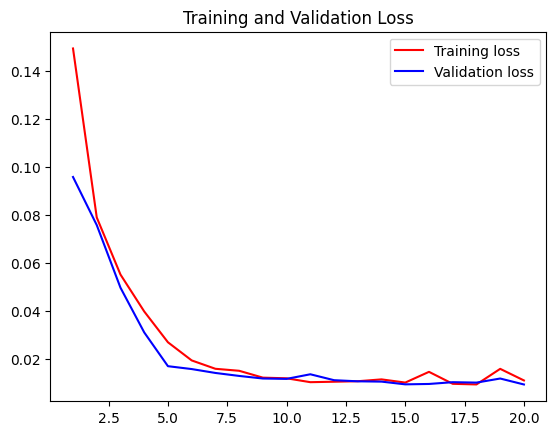

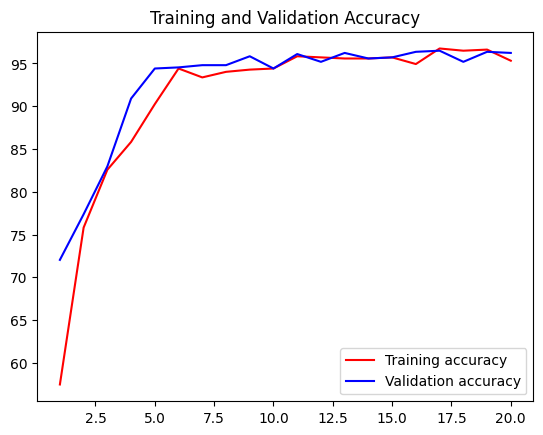

In [ ]:
train(epochs=20)

Accuracy: 97.40%
F1 Score: 0.96
Precision: 0.96
Recall: 0.96


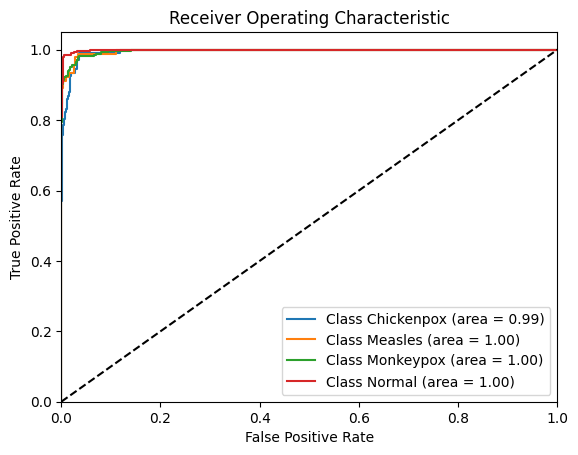

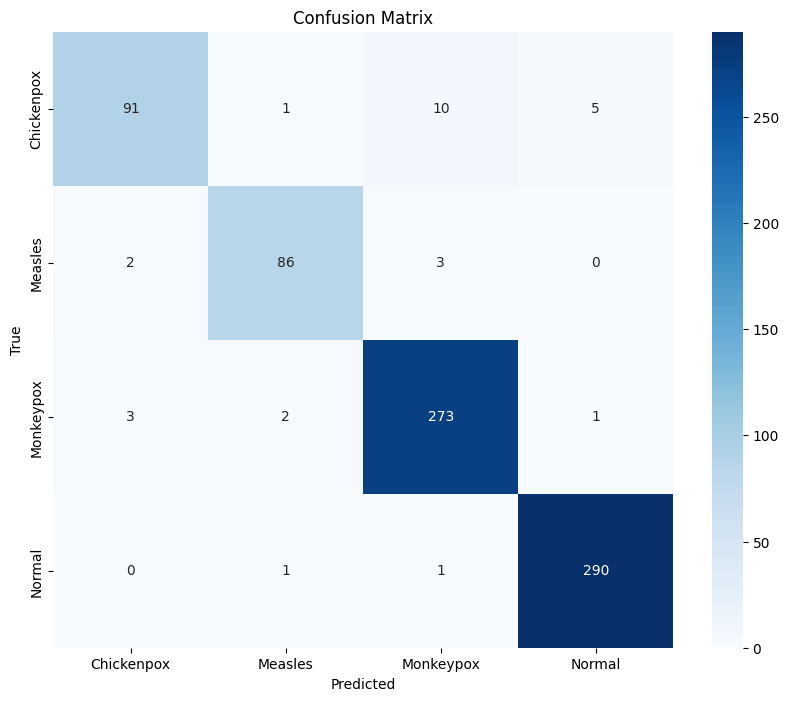

In [ ]:
calculate_accuracy()
# F1-Score, Recall and Precision 
calculate_metrics()
# ROC and Confusion Matrix
plot_roc_curve()
plot_confusion_matrix()

In [19]:
# Modeli kaydet
model_path = "/content/drive/MyDrive/MPox/alexnet.pth"
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")

Model saved to /content/drive/MyDrive/MPox/alexnet.pth


In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv
from torch_geometric.data import Dataset, DataLoader
from torchvision.models import vit_b_16, ViT_B_16_Weights
from torchvision import transforms
from PIL import Image
import os
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report



In [ ]:
from torchvision.models import alexnet, AlexNet_Weights

# CNN-GNN-ViT model class definition
class CNN_GNN_AlexNet(nn.Module):
    def __init__(self, num_classes):
        super(CNN_GNN_AlexNet, self).__init__()
        self.alexnet = alexnet(weights=AlexNet_Weights.IMAGENET1K_V1)
        self.alexnet.classifier[6] = nn.Linear(self.alexnet.classifier[6].in_features, 256)  

        # GNN layers
        self.conv1 = SAGEConv(256, 128)
        self.conv2 = SAGEConv(128, num_classes)

    def forward(self, x, edge_index, batch):
        x = self.alexnet(x)  
        x = self.conv1(x, edge_index)  
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)  
        return F.log_softmax(x, dim=1)


# Custom dataset class for loading images from subdirectories
class ImageDataset(Dataset):
    def __init__(self, root_dir, class_names, transform=None):
        self.root_dir = root_dir
        self.class_names = class_names
        self.transform = transform
        self.img_paths = []
        self.labels = []

        for class_idx, class_name in enumerate(class_names):
            class_dir = os.path.join(root_dir, class_name)
            img_names = os.listdir(class_dir)
            random.shuffle(img_names)
            selected_imgs = img_names[:40]  

            for img_name in selected_imgs:
                img_path = os.path.join(class_dir, img_name)
                self.img_paths.append(img_path)
                self.labels.append(class_idx)

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        label = self.labels[idx]
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, label


In [ ]:

# Function to create graph data from image features
def create_graph_data(features):
    num_nodes = features.size(0)
    edge_index = torch.combinations(torch.arange(num_nodes), r=2).t()
    x = features.clone().detach()
    return Data(x=x, edge_index=edge_index)

# Example root directory and class names
root_dir = "/content/drive/MyDrive/MPox/MonkeypoxSkinImagesDataset"
class_names = ['Chickenpox', 'Measles','Monkeypox','Normal']

model_path = '/content/drive/MyDrive/MPox/alexnet.pth'
model = CNN_GNN_AlexNet(num_classes=len(class_names))
model.load_state_dict(torch.load(model_path))
model.eval()

# Image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


<ipython-input-22-11af63b464e0>:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Overall Accuracy: 0.80


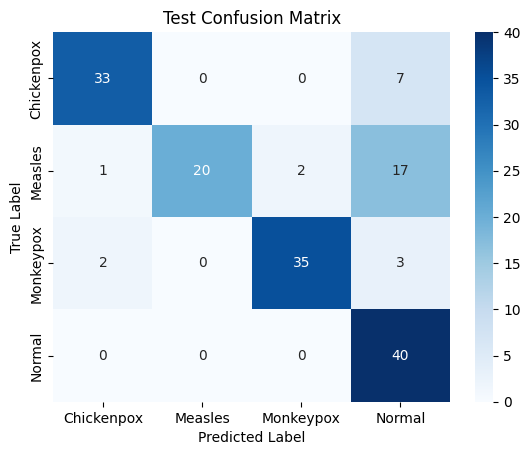

              precision    recall  f1-score   support

  Chickenpox       0.92      0.82      0.87        40
     Measles       1.00      0.50      0.67        40
   Monkeypox       0.95      0.88      0.91        40
      Normal       0.60      1.00      0.75        40

    accuracy                           0.80       160
   macro avg       0.86      0.80      0.80       160
weighted avg       0.86      0.80      0.80       160



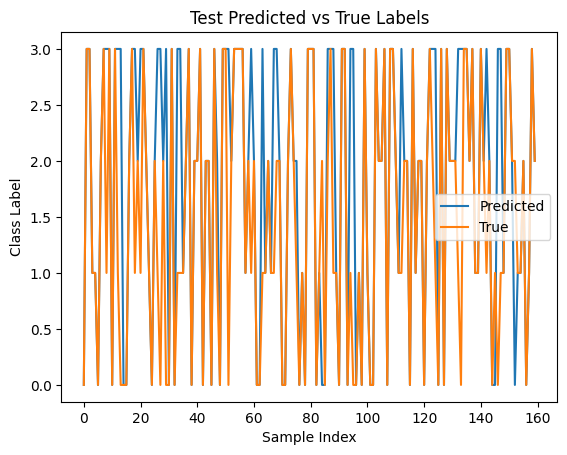

In [26]:

dataset = ImageDataset(root_dir=root_dir, class_names=class_names, transform=transform)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Testing and metrics calculation
all_labels = []
all_preds = []

with torch.no_grad():
    for img, label in dataloader:
        img = img.to(device)
        data = create_graph_data(img)
        data = data.to(device)

        output = model(data.x, data.edge_index, data.batch)
        _, predicted = torch.max(output.data, 1)
        class_idx = predicted.item()

        all_labels.append(label.item())
        all_preds.append(class_idx)

# Calculate accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f'Overall Accuracy: {accuracy:.2f}')

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Test Confusion Matrix')
plt.show()

# Classification report
print(classification_report(all_labels, all_preds, target_names=class_names))

# Plot accuracy graph
plt.figure()
plt.plot(np.arange(len(all_preds)), all_preds, label='Predicted')
plt.plot(np.arange(len(all_labels)), all_labels, label='True')
plt.xlabel('Sample Index')
plt.ylabel('Class Label')
plt.title('Test Predicted vs True Labels')
plt.legend()
plt.show()